# Clustering

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
sns.set_style("darkgrid")

## Load the required data

In [2]:
#Load data
package_tourism = pd.read_csv('data/package_tourism.csv')
tourism_rating = pd.read_csv('data/tourism_rating.csv')
tourism_with_id = pd.read_csv('data/tourism_with_id.csv')
user = pd.read_csv('data/user.csv')

In [3]:
# prepare ata for clustering based on location
location_data = tourism_with_id[['Lat', 'Long']].copy()

### Find optimal cluster count
<hr />

For **K-Means** clustering we need to find the optimal number of clusters to pass it to the algorithm. There are few methods to find the optimal clusters count like `Elbow method` and `Silhouette score`.

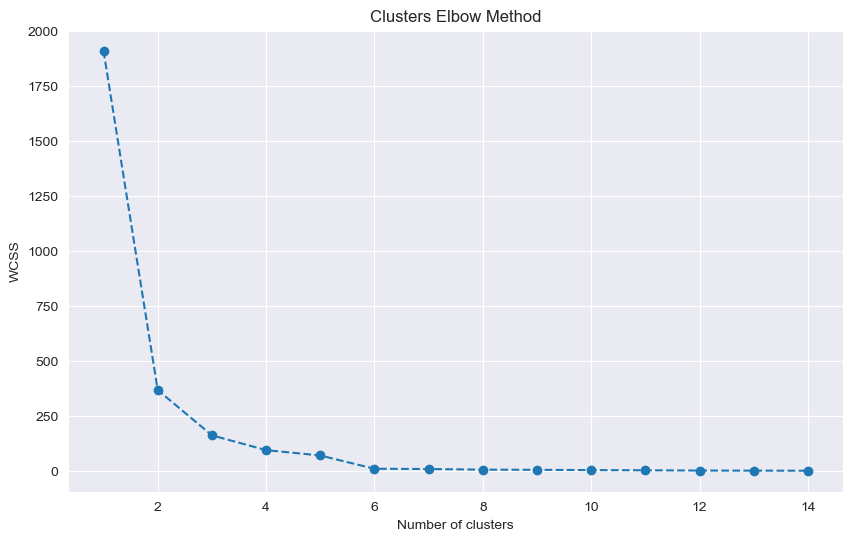

In [4]:
wcss = []

# calculating the within cluster sum of squares
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(location_data)
    wcss.append(kmeans.inertia_)

# plot the WCSS to find optimal cluster based on elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.title('Clusters Elbow Method')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Optimal cluster**
> **Note:**
>
>Based on the `Elbow Method`  here we can see the within cluster sum of squares is optimal at **`6`**.
>
>

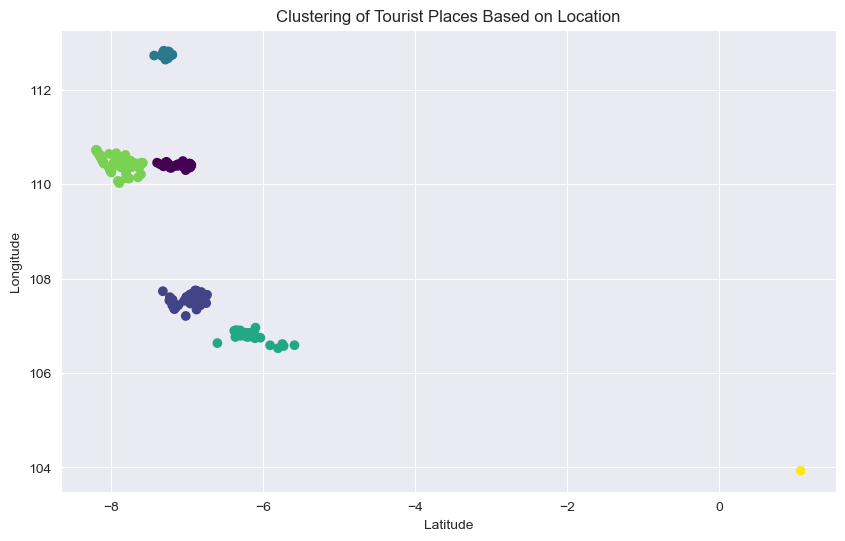

In [5]:
# Clustering
kmeans_cluster = KMeans(n_clusters=6, random_state=32)
location_data['Cluster'] = kmeans_cluster.fit_predict(location_data)

# Plot cluster results
plt.figure(figsize=(10, 6))
plt.scatter(location_data['Lat'], location_data['Long'], c=location_data['Cluster'], cmap="viridis")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clustering of Tourist Places Based on Location')
plt.show()

In [6]:
# adding cluster name to tourism dataframe
tourism_with_id_clustered = tourism_with_id.copy()
tourism_with_id_clustered['Cluster'] = location_data['Cluster']


#### Transform category data

In [7]:
# changing the category name to english for readability
tourism_with_id_clustered['Category'] = tourism_with_id_clustered['Category'].map({
    'Budaya': 'Culture',
    'Taman Hiburan': 'Amusement Park', 
    'Cagar Alam': 'Nature Reserve',
    'Bahari': 'Maritime',
    'Pusat Perbelanjaan': 'Shopping Center',
    'Tempat Ibadah': 'Worship Place'
    })

## Analyzing data zone wise 

On each zone we analyze the `count of category`, `rating distribution` and `average spending` of tourist on each zone

In [8]:
# color coding for category
category_colors = {
    'Nature Reserve':'#35b779',
    'Maritime': '#31688e',
    'Culture':  '#440154',
    'Amusement Park': '#fde725',
    'Shopping Center': '#b4de2c',
    'Worship Place': '#482878'
}

#### Category wise tourist place on each zone

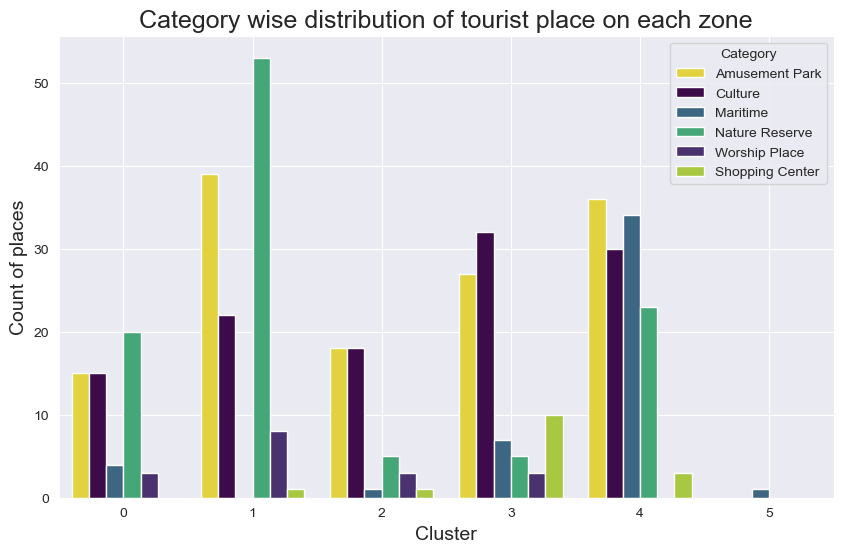

In [9]:
category_counts = tourism_with_id_clustered.groupby(['Cluster', 'Category']).size().reset_index(name='Count')

# Bar plot category wise on each zone
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Count', hue='Category', data=category_counts, palette=category_colors)
plt.title('Category wise distribution of tourist place on each zone', fontsize=18)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count of places', fontsize=14)
plt.grid(True)
plt.show()


#### Distribution of tourist spending on each zone

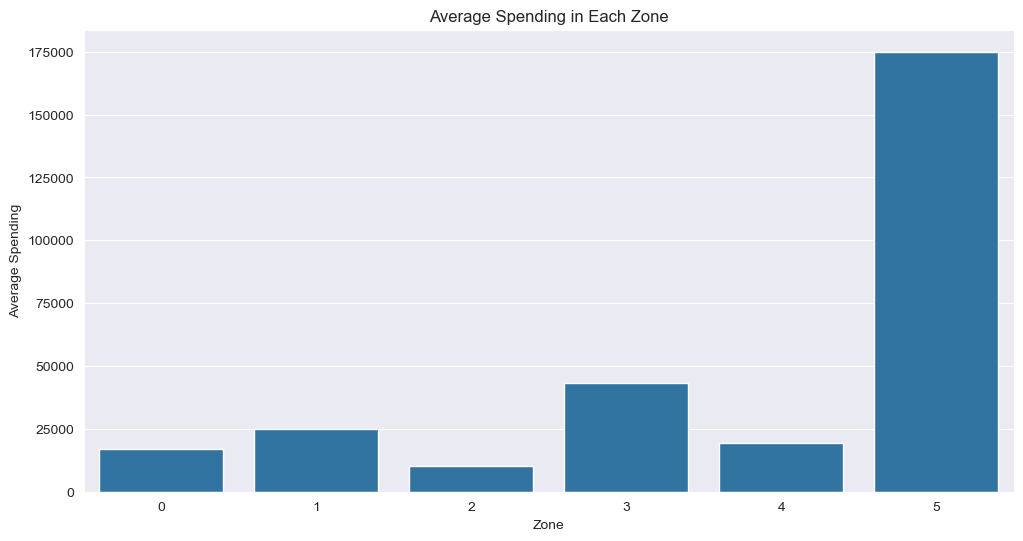

In [ ]:

# calculating the average spending by each zone
avg_spending_zone_wise = tourism_with_id_clustered.groupby('Cluster')['Price'].mean().reset_index()
avg_spending_zone_wise.columns = ['Zone', 'Average Spending']

# Plot the average spending in each zone
plt.figure(figsize=(12, 6))
sns.barplot(x='Zone', y='Average Spending', data=avg_spending_zone_wise)
plt.title('Average Spending in Each Zone')
plt.show()



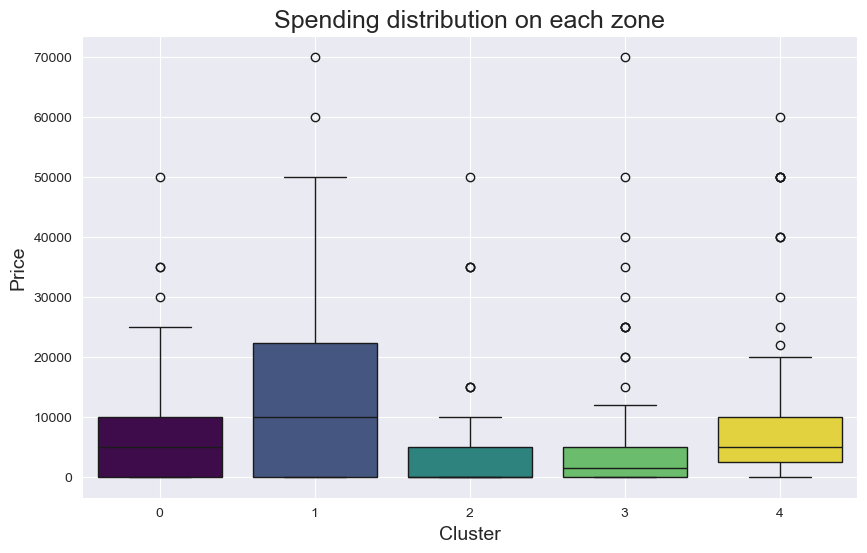

In [43]:

# Box plot of tourist spending on each place
plt.figure(figsize=(10, 6))
data = tourism_with_id_clustered[tourism_with_id_clustered['Price'] < 75000]
sns.boxplot(x='Cluster', y='Price', data=data, hue='Cluster', palette='viridis')

# Plot informative
plt.title('Spending distribution on each zone', fontsize=18)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.legend().set_visible(False)
plt.show()


##### Distribution of each zone

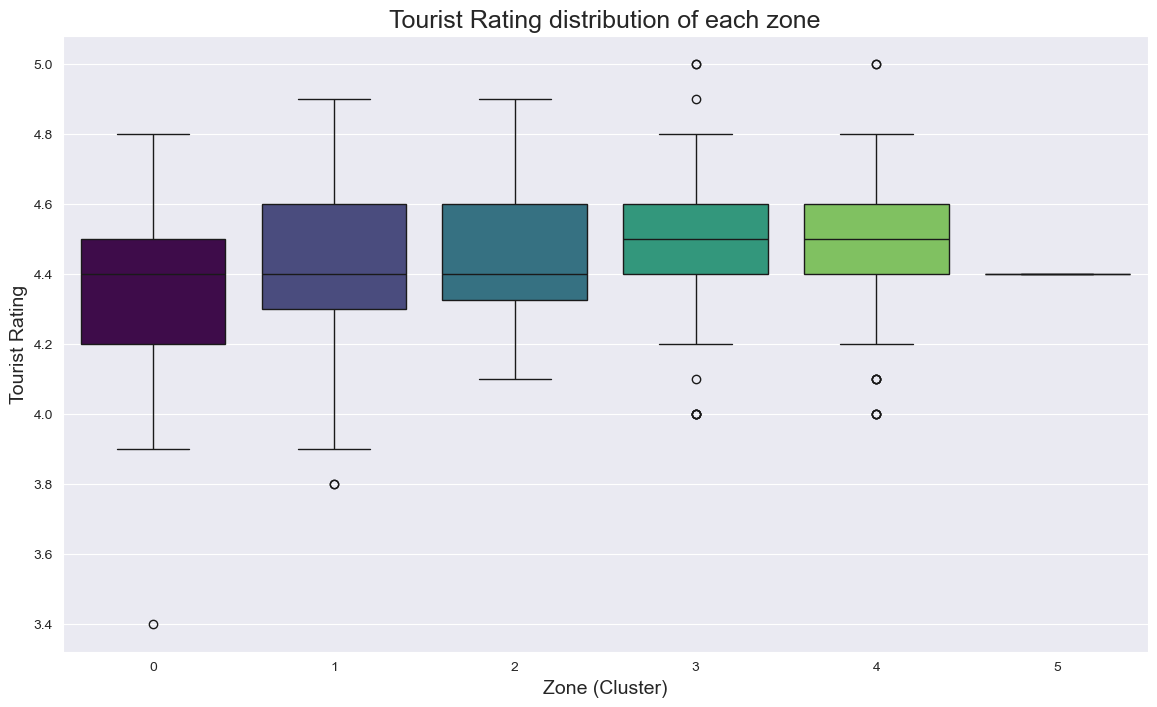

In [44]:
#Box plot of rating

plt.figure(figsize=(14, 8))
sns.boxplot(data=tourism_with_id_clustered,
             x='Cluster', y='Rating', hue='Cluster', palette='viridis')


plt.title('Tourist Rating distribution of each zone', fontsize=18, fontweight='medium')
plt.xlabel('Zone (Cluster)', fontsize=14)
plt.ylabel('Tourist Rating', fontsize=14)
plt.legend().set_visible(False)
plt.show()


#### Plot the zone in map

To plot the zone in Indonesian map we need to find the boundary of each zone and draw a boundary to map.

In [ ]:


zone_boundaries = tourism_with_id_clustered.groupby('Cluster').agg({
	'Lat': ['max', 'min'],
	'Long': ['max', 'min']
}).reset_index()

zone_boundaries.columns = ['Cluster', 'Lat_Max', 'Lat_Min', 'Long_Max', 'Long_Min']

# Create manhattan polygon for each zone
def create_manhattan_polygon(row):
	return Polygon([
		(row['Long_Min'], row['Lat_Min']),
		(row['Long_Min'], row['Lat_Max']),
		(row['Long_Max'], row['Lat_Max']),
		(row['Long_Max'], row['Lat_Min']),
		(row['Long_Min'], row['Lat_Min'])
	])

zone_boundaries['geometry'] = zone_boundaries.apply(create_manhattan_polygon, axis=1)

# Convert boundary to geodataframe
zone_boundaries_gdf = gpd.GeoDataFrame(zone_boundaries, geometry='geometry')



<Figure size 1200x1000 with 0 Axes>

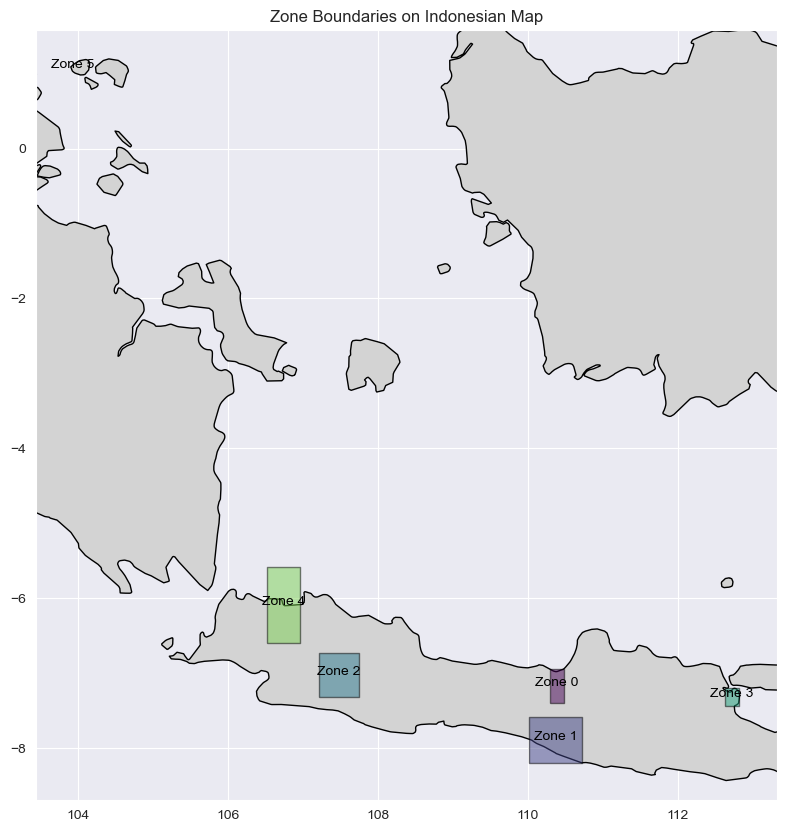

In [ ]:
# Load map of Indonesia
indonesia_map = gpd.read_file('map/indonesia.shp')

plt.figure(figsize=(12, 10))

ax=indonesia_map.plot(color='lightgrey', edgecolor='black', figsize=(12, 10))
zone_boundaries_gdf.plot(ax=ax, alpha=0.5, edgecolor='black', cmap='viridis')


# Add label text to each zone
for x, y, label in zip(zone_boundaries_gdf.geometry.centroid.x, 
                        zone_boundaries_gdf.geometry.centroid.y, 
                        zone_boundaries_gdf['Cluster']):
    plt.text(x, y, f'Zone {label}', fontsize=10, ha='center', color='black')

# ad padding to the zone boundary on each side
padding = 0.5  
x_min = zone_boundaries_gdf['Long_Min'].min() - padding
x_max = zone_boundaries_gdf['Long_Max'].max() + padding
y_min = zone_boundaries_gdf['Lat_Min'].min() - padding
y_max = zone_boundaries_gdf['Lat_Max'].max() + padding

# Zoom the map of interest
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.title('Zone Boundaries on Indonesian Map')
plt.show()


## Observations

### Zone 0
- It is a mix of attractions with good amount of `Amusement Park`, `Culture` and `Nature Reserve`
- There are few `Maritime` and `Worship Place`
- It has the various options based on the price range ranging from `0` to `35,000` IDR
- Rating distribution ranges from `3.9` to `4.8` with average rating of `4.4`


### Zone 1
- This zone has balanced variety of different range of attractions
- This zone has attractions with highest spending average
- It has highest average rating of `4.5`


### Zone 2
- This zone has most of the `Maritime` attraction and good mix of `Amusement Park` and `Culture`
- This is the most affordable zone with almost `0` mean
- It has the lowest average rating of `4.4`


### Zone 3

- This zone has least variety and count of attractions
- Also the second most affordable zone based on average attraction
- It has the lowest average rating of `4.4`


### Zone 4
- It has good mix of  `Amusement Park` and  `Culture`, with few other options of `Maritime`, `Nature Reserve`, `Worship Place` and `Shopping Center`
- It is the average zone in terms all other zones
- Has a good average rating of `4.5`

### Zone 5 
- It has the only one place